In [1]:
cd /home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-2023

/home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-2023


In [2]:
from dataclasses import dataclass
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display

In [3]:
results_root = pathlib.Path('results/multiclass/BFSongRepo/')

In [4]:
@dataclass
class ModelMetadata:
    """Class that represents a trained model + metadata"""
    results_dir: str
    window_size: int
    loss: str
    hyperparameters: str | None = None

In [5]:
COLUMNS = [
    'model_name', 'dataset', 'train_dur', 'replicate_num', 'window_size', 'loss',
    'avg_val_acc_epoch', 'avg_val_acc_tfm_epoch', 
    'avg_val_levenshtein_epoch', 'avg_val_levenshtein_tfm_epoch', 
    'avg_val_loss_epoch',
    'avg_val_character_error_rate_epoch', 'avg_val_character_error_rate_tfm_epoch',
    'avg_val_precision_epoch', 'avg_val_precision_tfm_epoch',
    'avg_val_recall_epoch', 'avg_val_recall_tfm_epoch',
    'avg_val_fscore_epoch', 'avg_val_fscore_tfm_epoch',
]


def df_from_model_metadata_map(model_metadata_map: dict) -> pd.DataFrame:
    results_df = []

    for model_name, dataset_metadata_list_map in model_metadata_map.items():
        for dataset_name, metadata_list in dataset_metadata_list_map.items():
            for metadata in metadata_list:
                csv_path = results_root / dataset_name / model_name / metadata.results_dir / 'learning_curve.csv'
                df = pd.read_csv(csv_path)
                df['dataset'] = dataset_name
                df['window_size'] = metadata.window_size
                df['loss'] = metadata.loss
                df = df[COLUMNS]
                results_df.append(df)

    results_df = pd.concat(results_df)

    columns = {
        column_old: column_old.replace('avg_val_', '').replace('_epoch', '') 
        if column_old.startswith('avg_val') else column_old
        for column_old in results_df.columns
    }
    columns.update(
        {
            'model_name': 'Model',
            'window_size': 'Window Size',
            'hyperparameters': 'Hyperparameters',
            'train_dur': 'Training set size (s)',
            'loss': 'Loss',
        }
    )
    results_df = results_df.rename(columns=columns)

    results_df['frame_error'] = (1.0 - results_df['acc']) * 100
    results_df['frame_error_tfm'] = (1.0 - results_df['acc_tfm']) * 100
    for metric_name in (
        'character_error_rate',
        'character_error_rate_tfm',
        'precision',
        'precision_tfm',
        'recall',
        'recall_tfm',
        'fscore',
        'fscore_tfm',
    ):
        results_df[metric_name] = results_df[metric_name] * 100

    return results_df

In [6]:
MODEL_METADATA_MAP = {
    'TweetyNet': {
        'all-birds': [
            ModelMetadata(
                results_dir='results_231025_222720',
                window_size=2000,
                loss='CE',
            ),
            ModelMetadata(
                results_dir='results_231028_080948',
                window_size=2000,
                loss='CE+TMSE',
            ),
            ModelMetadata(
                results_dir='results_231028_124122',
                window_size=2000,
                loss='CE+gsTMSE',
            ),
        ],
    },
    'ConvTemporalConvNet': {
        'all-birds': [
            ModelMetadata(
                results_dir='results_231025_222812',
                window_size=2000,
                loss='CE'
            ),
            ModelMetadata(
                results_dir='results_231027_162429',
                window_size=2000,
                loss='CE+TMSE',
            ),
            ModelMetadata(
                results_dir='results_231027_162459',
                window_size=2000,
                loss='CE+gsTMSE',
            ),
        ],
    },
}

In [7]:
data = df_from_model_metadata_map(MODEL_METADATA_MAP)

data = data.drop(columns='dataset')

id_vars = [
    'Model',
    'Training set size (s)',
    'replicate_num',
    'Loss',
]

value_vars = [
    'character_error_rate',
    'character_error_rate_tfm',
    'precision',
    'precision_tfm',
    'recall',
    'recall_tfm',
    'fscore',
    'fscore_tfm',
    'frame_error',
    'frame_error_tfm'
]

data = data.melt(id_vars=id_vars, value_vars=value_vars)

data['Post-processing'] = data['variable'].apply(lambda x: x.endswith('_tfm'))

var_metric_map = dict(zip((
    'frame_error',
    'frame_error_tfm',
    'character_error_rate',
    'character_error_rate_tfm',
    'precision',
    'precision_tfm',
    'recall',
    'recall_tfm',
    'fscore',
    'fscore_tfm',
),
(
    'Frame Error (%)',
    'Frame Error (%)',
    'Character Error Rate (%)',
    'Character Error Rate (%)',
    'Precision (%)',
    'Precision (%)',
    'Recall (%)',
    'Recall (%)',
    '$F$-score (%)',
    '$F$-score (%)',
)))

data['Metric'] = data['variable'].map(var_metric_map)

def condition(row):
    loss = row['Loss']
    postprocess = row['Post-processing']
    condition_str = f'Loss: {loss}'
    if postprocess:
        condition_str += ' with clean-ups'
    return condition_str

In [8]:
@dataclass
class MetricPlot:
    metric: str
    ascending: bool
    ylim: list[int]
    save_fname: str
    legend_loc: str

In [9]:
metrics_plots = (
    MetricPlot(
        metric='Frame Error (%)',
        ascending=True,
        ylim=[0., 1.8],
        save_fname='loss-frame-error',
        legend_loc='lower right',
    ),
    MetricPlot(
        metric='Character Error Rate (%)',
        ascending=True,
        ylim=[0., 28.],
        save_fname='loss-character-error-rate',
        legend_loc='upper right',
    ),
    MetricPlot(
        metric='Precision (%)',
        ascending=False,
        ylim=[80, 100],
        save_fname='loss-precision',
        legend_loc='lower right',
    ),
    MetricPlot(
        metric='Recall (%)',
        ascending=False,
        ylim=[80, 100],
        save_fname='loss-recall',
        legend_loc='lower right',
    ),
    MetricPlot(
        metric='$F$-score (%)',
        ascending=False,
        ylim=[92.5, 100],
        save_fname='loss-fscore',
        legend_loc='upper left',
    ),
)

In [10]:
sns.set()
sns.set_context('poster', font_scale=1.5)

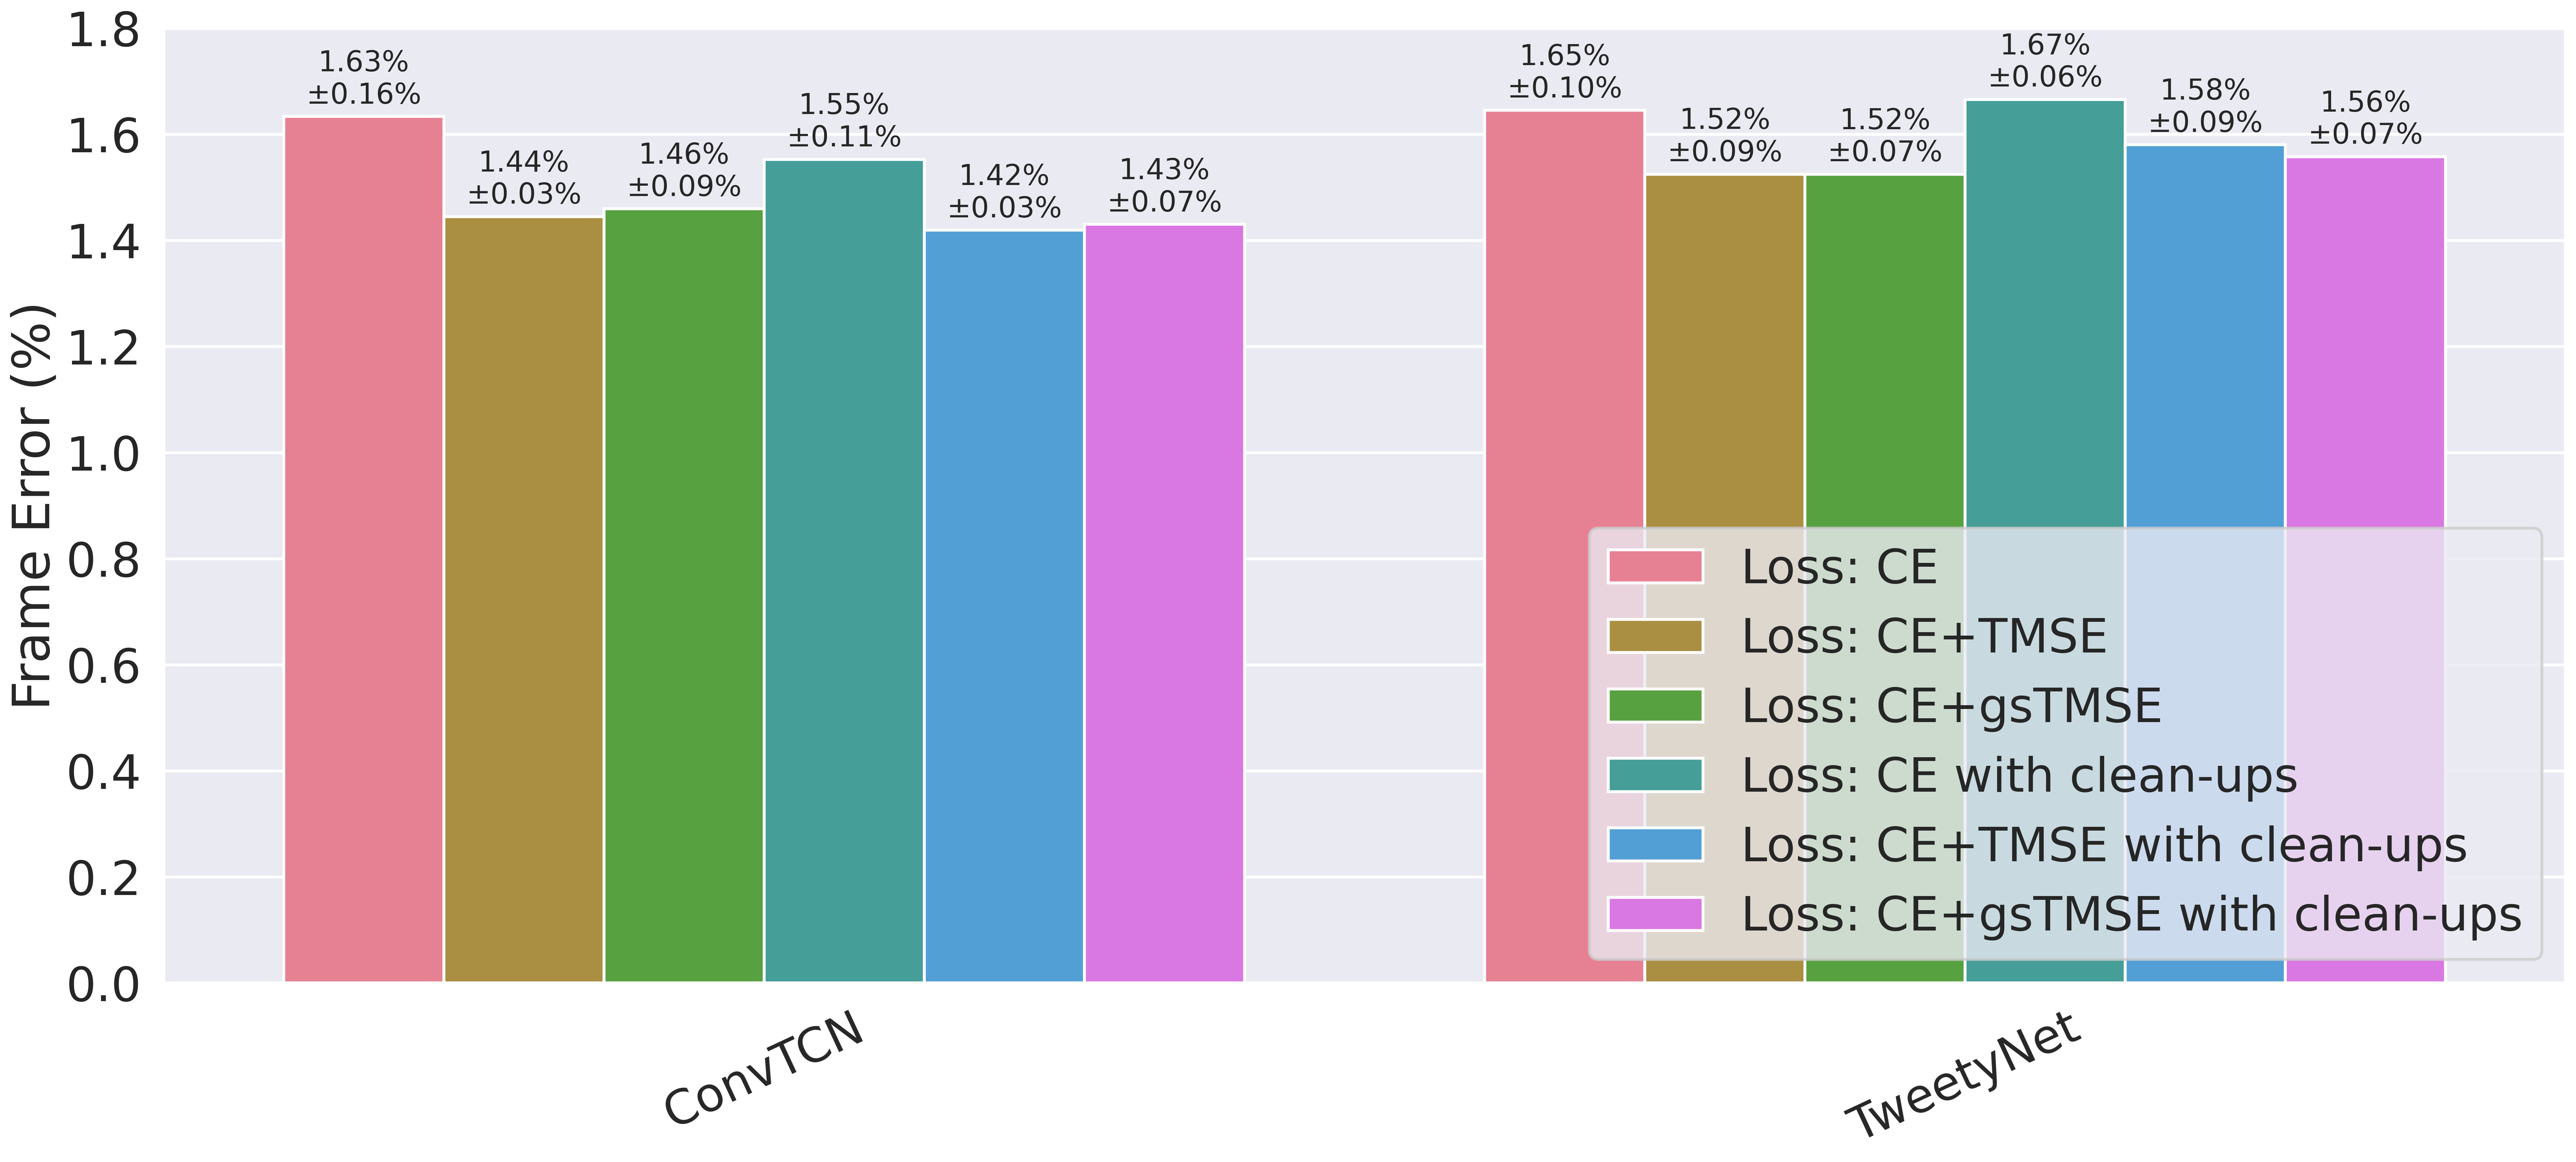

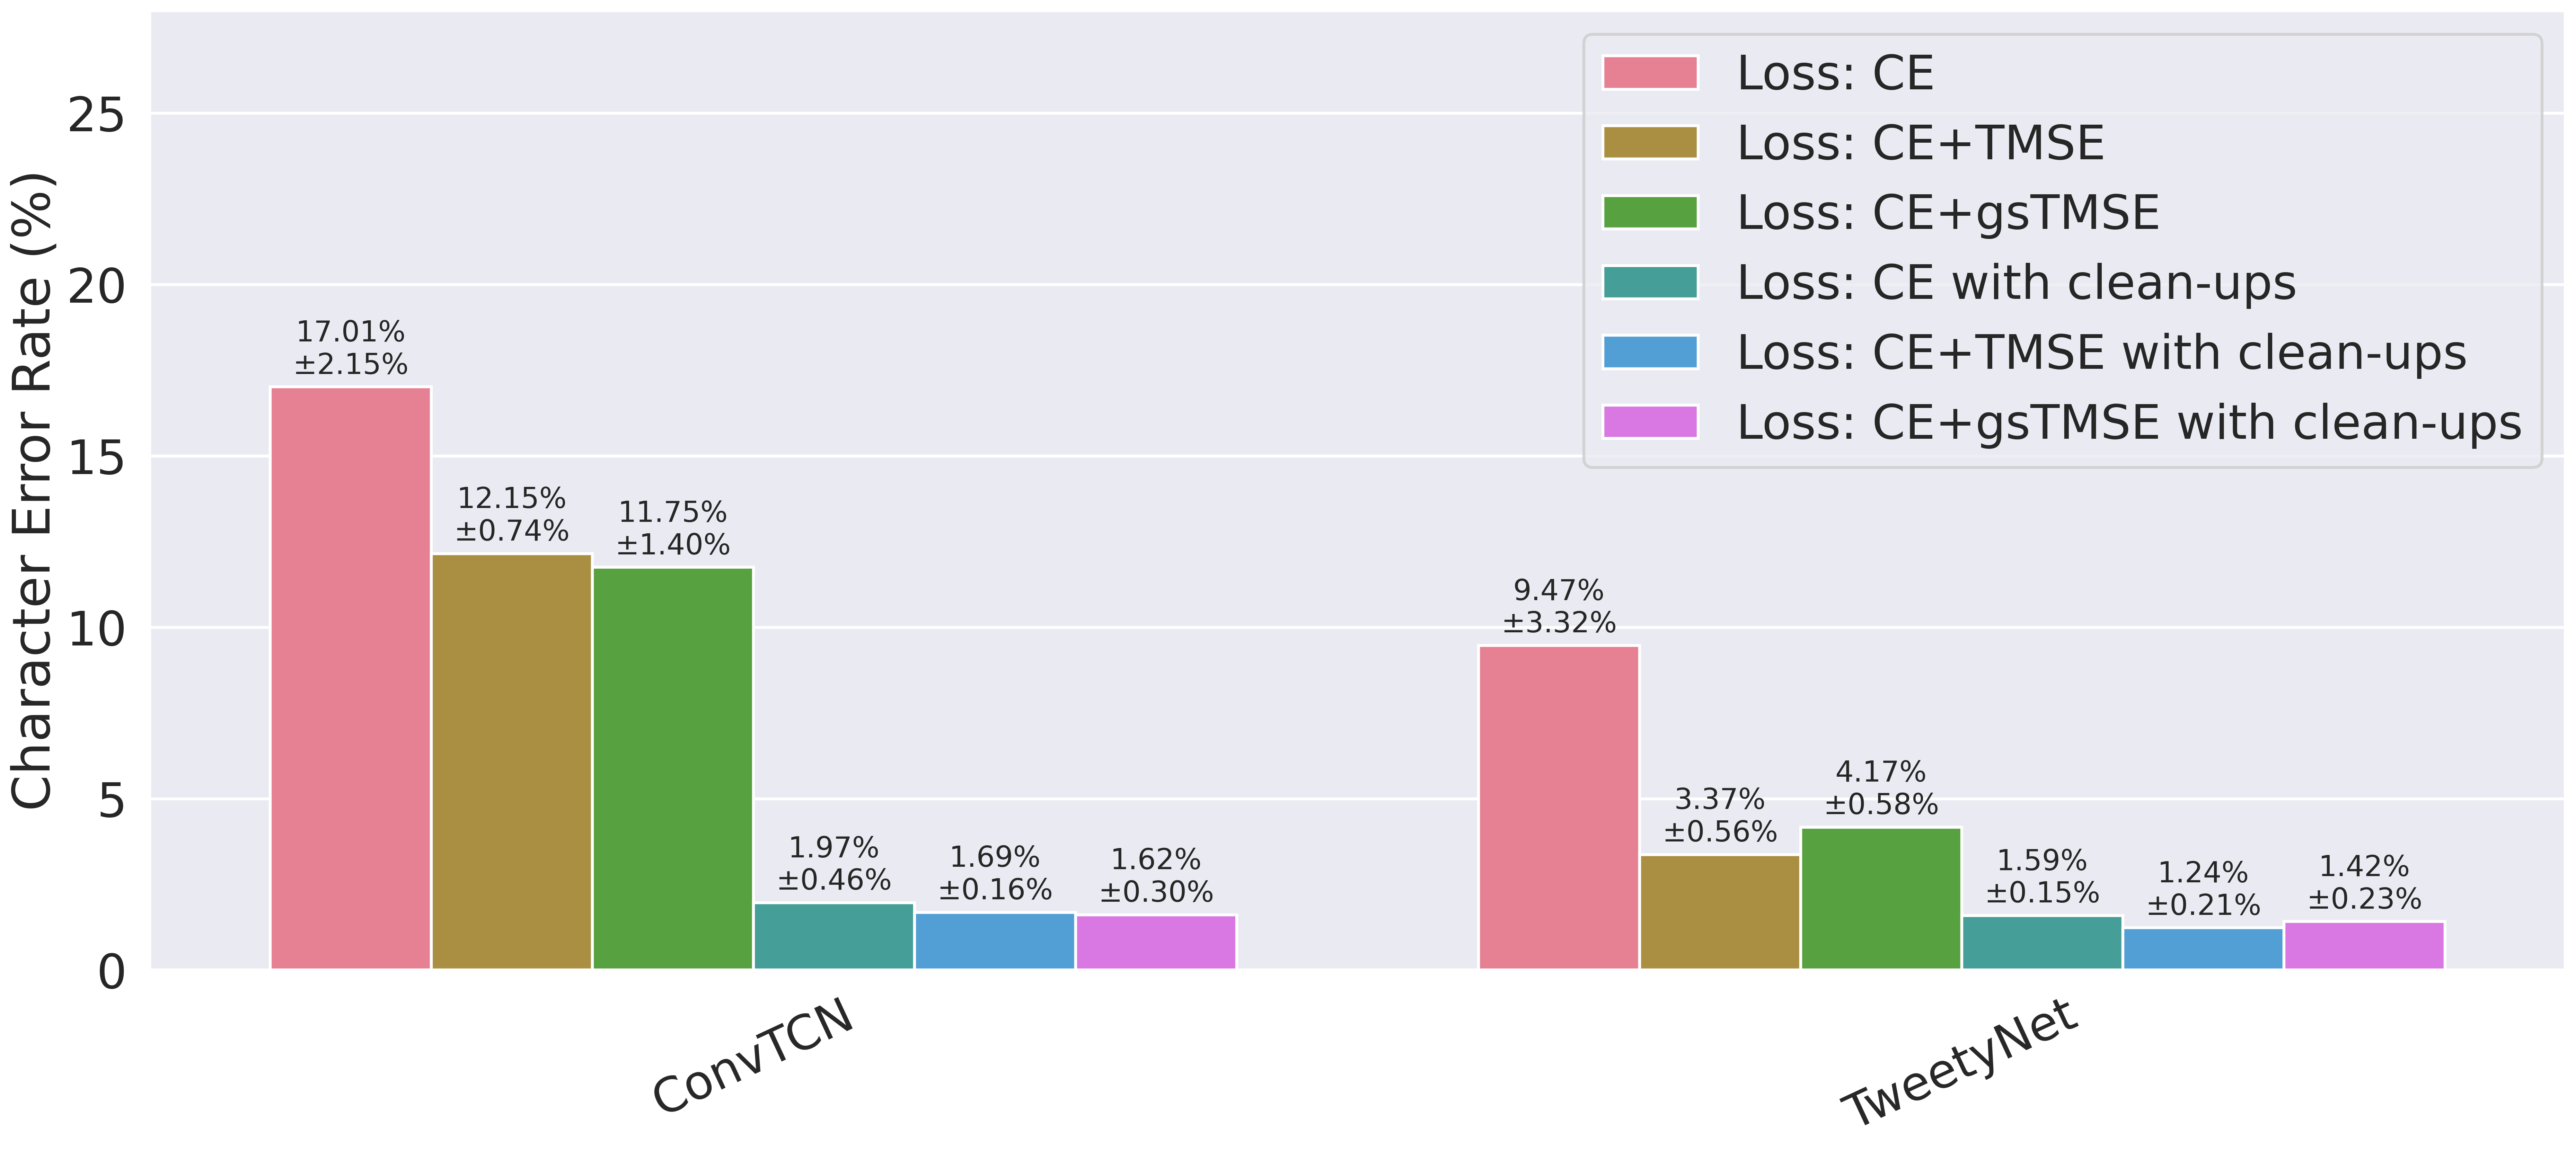

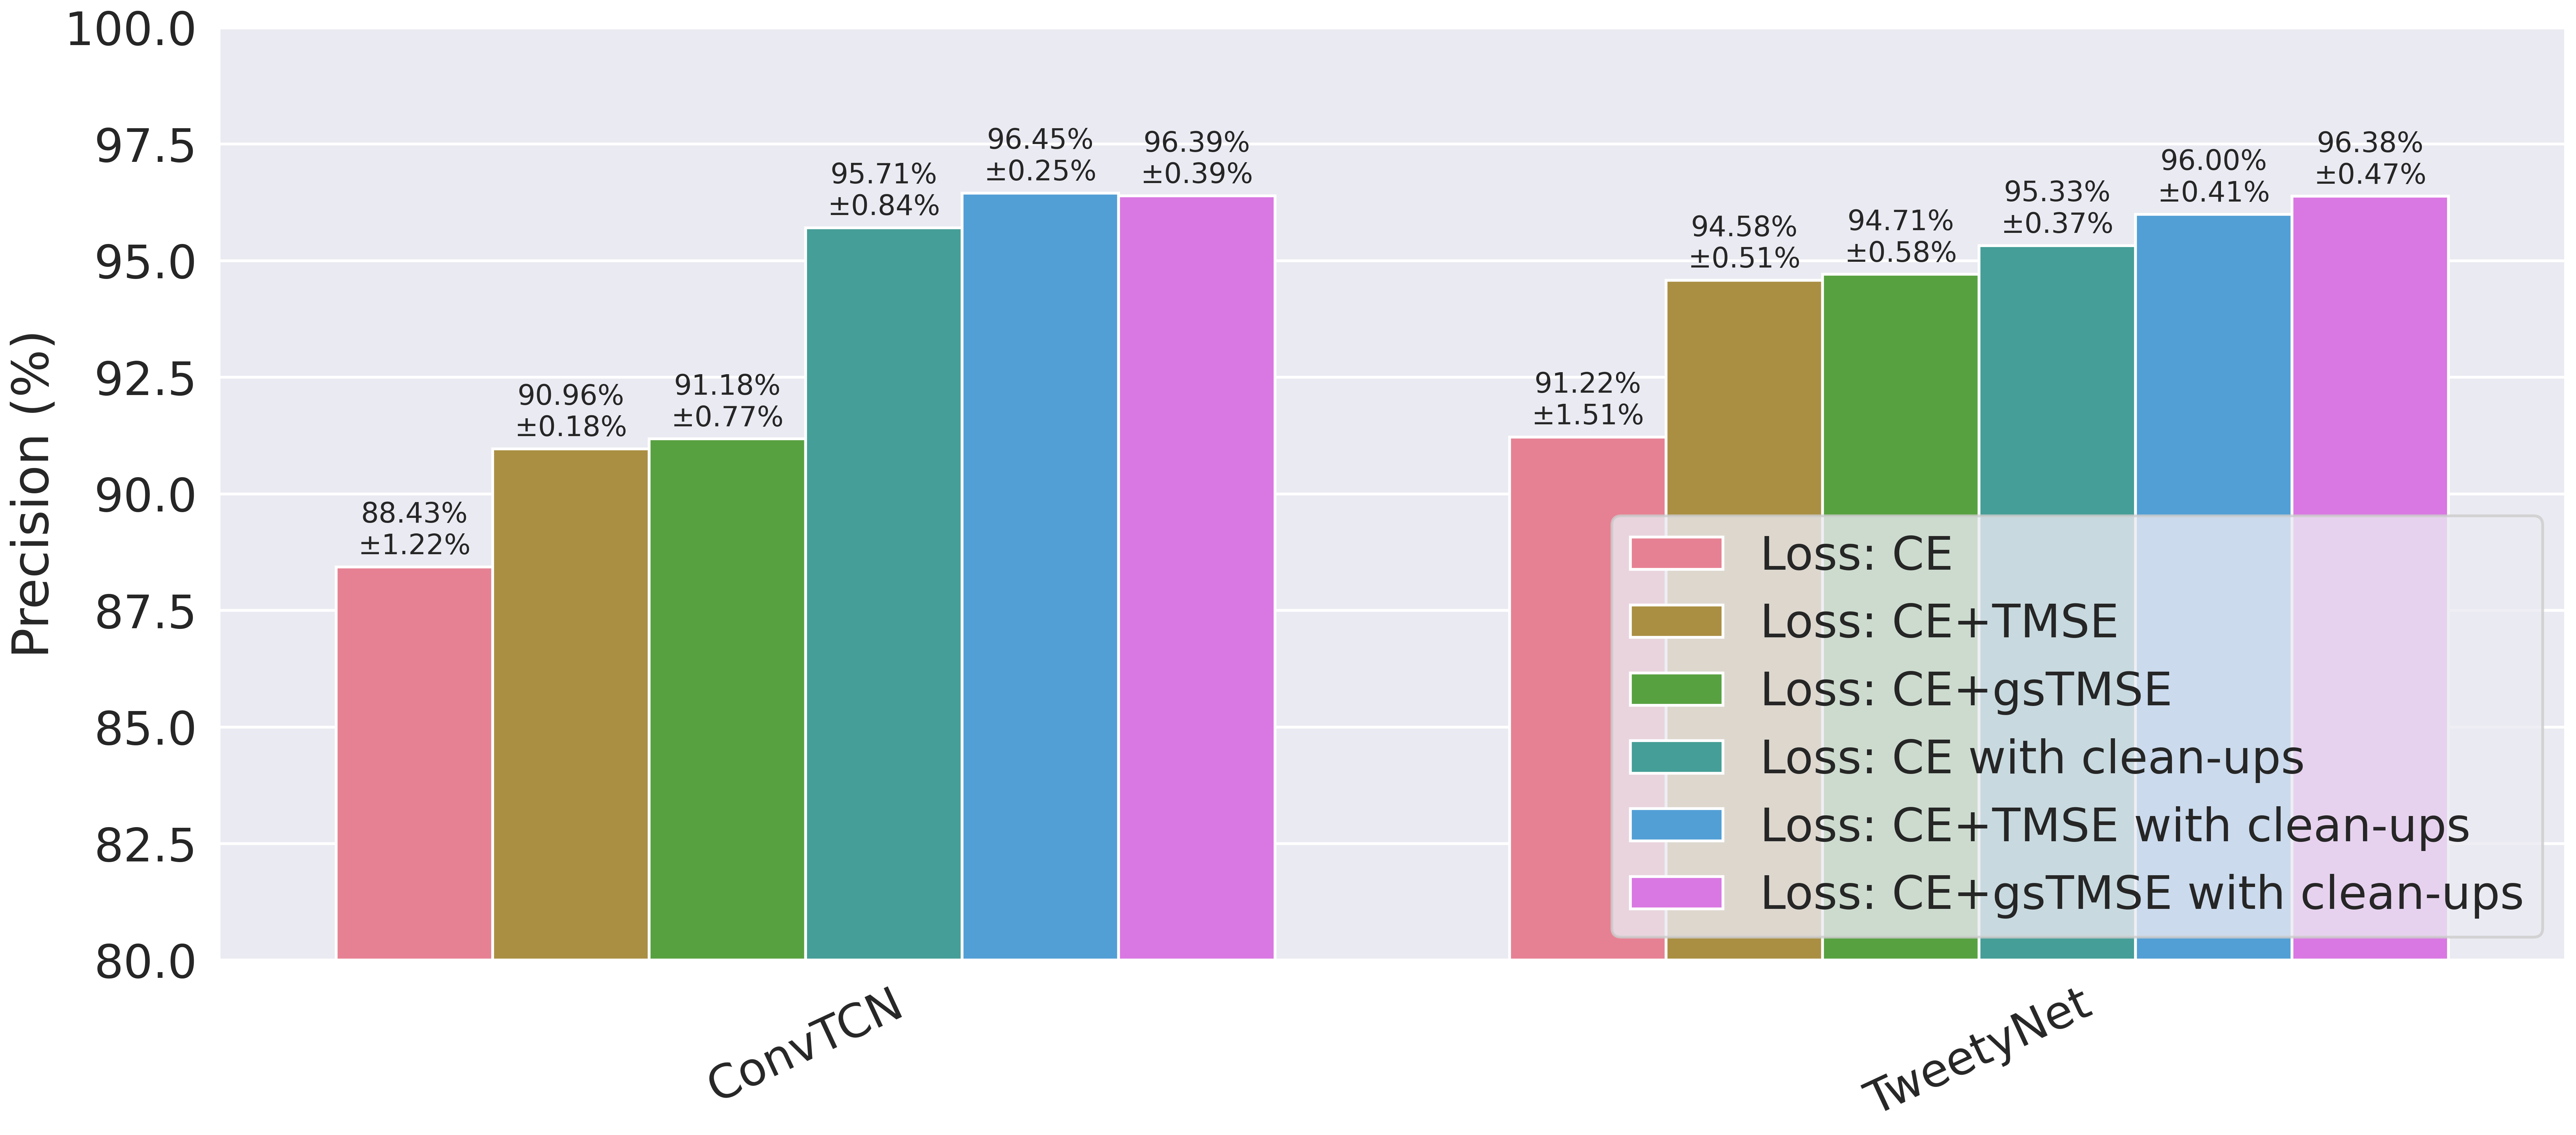

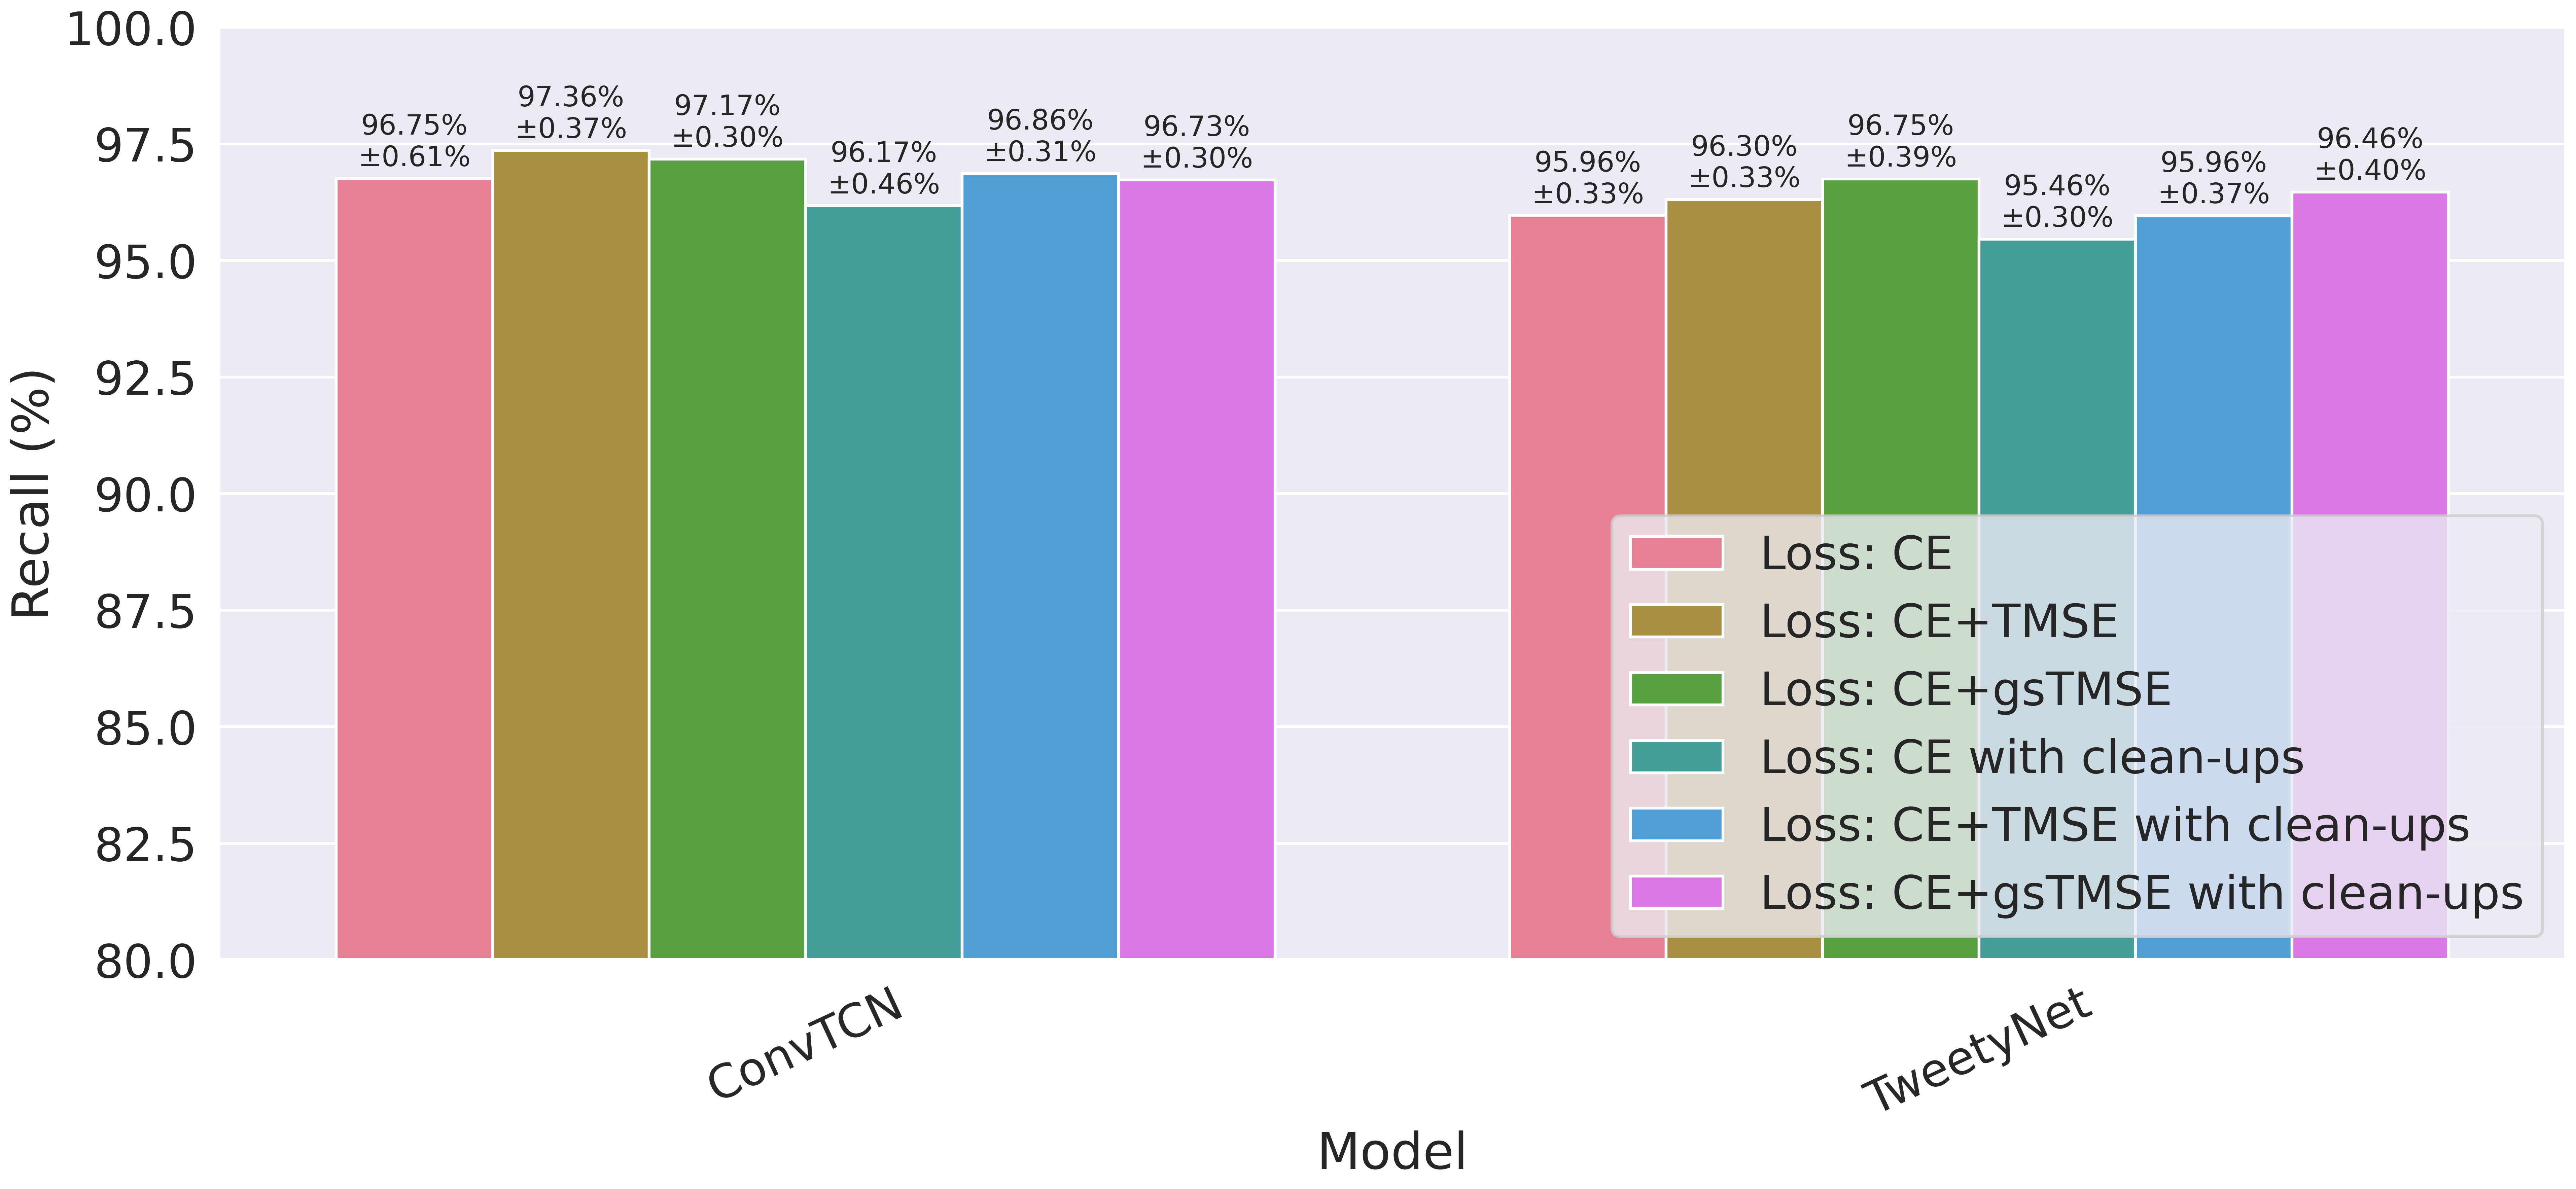

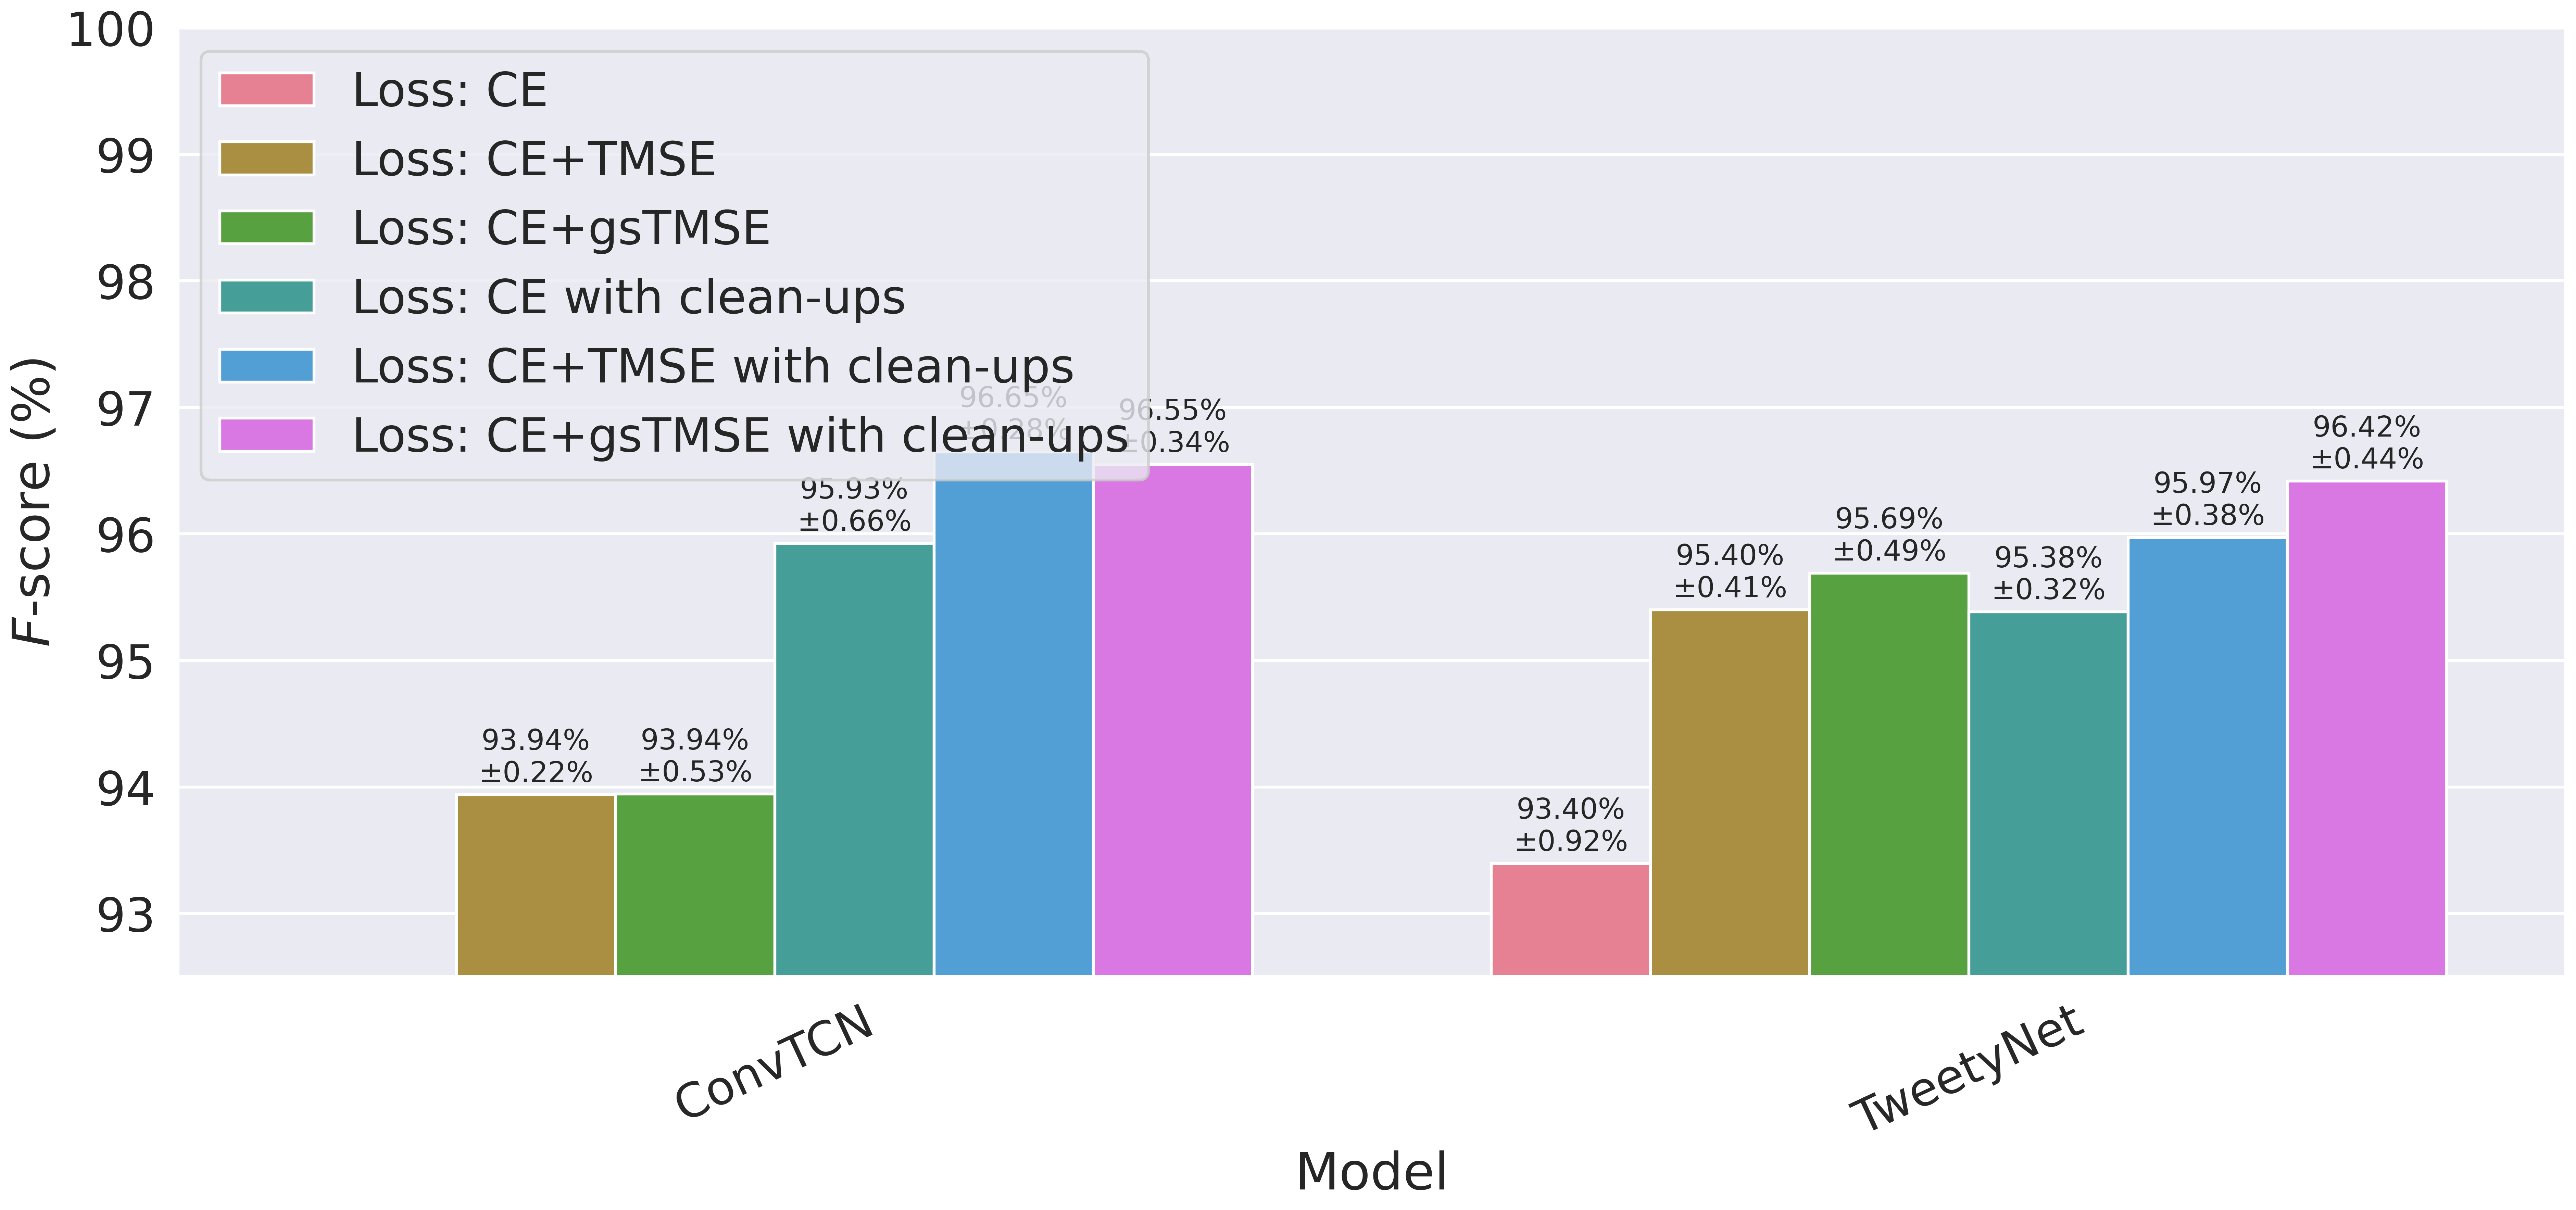

In [12]:
for metrics_plot_num, metrics_plot in enumerate(metrics_plots):
    data_metric = data[data['Metric'] == metrics_plot.metric]
    gb = data_metric.groupby(by=['Model', 'Loss', 'Metric', 'Post-processing']).agg(
        mean=pd.NamedAgg("value", "mean"),
        std=pd.NamedAgg("value", "std"),
    ).reset_index()
    gb = gb.sort_values(by=['Model', 'Post-processing', 'Loss',], ascending=(True, True, True))
    gb['Condition'] = gb.apply(condition, axis=1)
    gb['Model'] = gb['Model'].map(lambda x: x.replace('TemporalConvNet', 'TCN'))

    fig, ax = plt.subplots(1, 1, figsize=(30, 12), dpi=300)
    g = sns.barplot(
        data=gb,
        x='Model',
        y='mean',
        hue='Condition',
        ax=ax,
        palette='husl',
    )
    ax.set_ylabel(metrics_plot.metric)
    ax.tick_params(axis='x', rotation=25)
    ax.set_ylim(metrics_plot.ylim)
    
    for bar, condition_ in zip(ax.containers, gb['Condition'].unique()):
        condition_gb = gb[gb['Condition'] == condition_]
        labels = [f'{mean:.2f}%\n±{std:.2f}%' for mean, std in zip(condition_gb['mean'].values, condition_gb['std'].values)]
        ax.bar_label(
            bar,
            labels=labels,
            padding=5,
            fontsize=20
        )

    # ---- specific stuff for poster
    # don't put legend on CER or precision plot since it blocks other info
    sns.move_legend(ax, loc=metrics_plot.legend_loc)
    # ---- only put 'Model' on bottom plot
    if metrics_plot_num >= len(metrics_plots) - 2:
        pass
    else:
        ax.set_xlabel('')
    g.legend_.set_title(None)
    plt.savefig(f'doc/figures/poster-{metrics_plot.save_fname}.svg', bbox_inches="tight")